## Setup and Imports

First, let's import the necessary modules and set up our environment.

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import Dict, List, Tuple, Any

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    
# Import our modules
from src.gpt_from_scratch.trainer.trainer import ModelTrainer
from src.gpt_from_scratch.classic_ngram.classic_ngram import NGramLM, read_lines, build_stream
from src.gpt_from_scratch.mini_gpt.mini_gpt import MiniGPT
from src.gpt_from_scratch.tokenizer.tokenizer_bpe import BPETokenizer
from src.gpt_from_scratch.neural_ngram.neural_ngram import NeuralNGramModel

# CHOOSE YOUR DEVICE - pick ONE of these options:

# # Option 1: Force CPU (safe but slower)
# os.environ["DEVICE"] = "cpu"
# device = torch.device("cpu")
# print(f"Using device: {device}")

# Option 2: Use MPS if available (faster but might have issues)
os.environ["DEVICE"] = "mps"
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using MPS device: {device}")
else:
    device = torch.device("cpu")
    print(f"MPS not available, using: {device}")

# Disable torch compile to avoid MPS compatibility issues
torch._dynamo.config.disable = True

Using MPS device: mps


## Data Loading

Let's load and prepare the data for our models.

In [ ]:
# define paths
DATA_DIR = project_root / "data/processed"
TRAIN_PATH = DATA_DIR / "train.txt"
VAL_PATH = DATA_DIR / "val.txt"
TOKENIZER_DIR = project_root / "tokenizers"

# create directories if they don't exist
DATA_DIR.mkdir(exist_ok=True, parents=True)
TOKENIZER_DIR.mkdir(exist_ok=True, parents=True)

# check if data exists, otherwise download/create sample data
if not TRAIN_PATH.exists() or not VAL_PATH.exists():
    print("Data files not found. Creating sample data...")
    
    # create simple sample data for demonstration
    sample_text = """
    The quick brown fox jumps over the lazy dog. 
    To be or not to be, that is the question.
    All that glitters is not gold.
    Actions speak louder than words.
    A picture is worth a thousand words.
    """
    
    # split into train/val
    lines = [line.strip() for line in sample_text.strip().split('\n') if line.strip()]
    train_lines = lines[:int(len(lines) * 0.8)]
    val_lines = lines[int(len(lines) * 0.8):]
    
    # write to files
    DATA_DIR.mkdir(exist_ok=True, parents=True)
    with open(TRAIN_PATH, 'w') as f:
        f.write('\n'.join(train_lines))
    with open(VAL_PATH, 'w') as f:
        f.write('\n'.join(val_lines))
    
    print(f"Created sample data at {TRAIN_PATH} and {VAL_PATH}")

# load the data
train_lines = read_lines(TRAIN_PATH)
val_lines = read_lines(VAL_PATH)

print(f"train_lines {train_lines}")

print(f"Loaded {len(train_lines)} training lines and {len(val_lines)} validation lines")
print("\nSample training data:")
for i, line in enumerate(train_lines[:3]):
    print(f"  {i+1}. {line}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Tokenizer Setup

Train a BPE tokenizer on our data.

In [ ]:
def train_tokenizer(merges: int = 200):
    """Train a BPE tokenizer on the training data."""
    tokenizer = BPETokenizer(
        seed=42,
        bos_token="<BOS>",
        eos_token="<EOS>",
        pad_token=None,
        unk_token=None,
        lowercase=True,
        unicode_normalization="NFKC",
        collapse_whitespace=True,
        keep_newlines=True,
    )
    
    # train on training data
    train_text = TRAIN_PATH.read_text(encoding="utf-8")
    tokenizer.train(
        train_text,
        merges=merges,
        guard_train_only=True,
        source_tag="train",
        min_pair_freq=1,
    )
    
    # save tokenizer
    tag = f"bpe_{merges:04d}"
    tokenizer.save(str(TOKENIZER_DIR), tag)
    
    print(f"Trained tokenizer with {merges} merges. Vocabulary size: {len(tokenizer.vocab)}")
    return tokenizer


#----------more extended training-------
# Train the tokenizer
#tokenizer = train_tokenizer(merges=200)

# for longer experiment
#merge_values = [200, 500, 1000]
#--------------------------------------

# for fastest experiment
merge_values = [200]

tokenizers = {}

for merges in merge_values:
    print(f"\n=== Training tokenizer with {merges} merges ===")
    tokenizers[merges] = train_tokenizer(merges=merges)
    
print(f"\nTrained {len(tokenizers)} tokenizers with merge counts: {list(tokenizers.keys())}")

tokenizer = tokenizers[200]

# test the tokenizer
sample_text = "The quick brown fox jumps over the lazy dog."
encoded = tokenizer.encode(sample_text, add_bos=True, add_eos=True)
decoded = tokenizer.decode(encoded)

print(f"\nOriginal: {sample_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")
print(f"Tokenized: {[tokenizer.decode([t]) for t in encoded]}")


=== Training tokenizer with 200 merges ===
Trained tokenizer with 200 merges. Vocabulary size: 458

=== Training tokenizer with 500 merges ===
Trained tokenizer with 500 merges. Vocabulary size: 758

=== Training tokenizer with 1000 merges ===
Trained tokenizer with 1000 merges. Vocabulary size: 1258

Trained 3 tokenizers with merge counts: [200, 500, 1000]

Original: The quick brown fox jumps over the lazy dog.
Encoded: [0, 297, 417, 107, 378, 295, 116, 425, 322, 113, 122, 34, 108, 119, 111, 114, 263, 113, 366, 298, 325, 124, 269, 102, 113, 105, 48, 1]
Decoded: the quick brown fox jumps over the lazy dog.
Tokenized: ['', 'the ', 'qu', 'i', 'ck', ' b', 'r', 'own', ' f', 'o', 'x', ' ', 'j', 'u', 'm', 'p', 's ', 'o', 'ver', ' the ', 'la', 'z', 'y ', 'd', 'o', 'g', '.', '']


## Prepare Data for Models

Convert text data to token streams for both model types.

In [ ]:
# process data for n-gram models
train_stream = build_stream(tokenizer, train_lines)
val_stream = build_stream(tokenizer, val_lines)

print(f"Train stream length: {len(train_stream)} tokens")
print(f"Val stream length: {len(val_stream)} tokens")

# create tensor datasets for neural models
def create_tensor_dataset(token_stream, context_size=64):
    data = torch.tensor(token_stream, dtype=torch.long)
    
    # create sequences of context_size + 1
    sequences = []
    for i in range(0, len(data) - context_size):
        seq = data[i:i+context_size+1]
        sequences.append(seq)
    
    if sequences:
        # stack sequences into a tensor
        tensor_data = torch.stack(sequences)
        
        # split into inputs and targets
        x = tensor_data[:, :-1]  # all but last token
        y = tensor_data[:, 1:]   # all but first token
        
        return x, y
    else:
        # handle case with too short data
        print("Warning: Data too short to create sequences!")
        return torch.tensor([], dtype=torch.long), torch.tensor([], dtype=torch.long)

# create tensor data for neural models
context_size = 64  # Context window size
x_train, y_train = create_tensor_dataset(train_stream, context_size)
x_val, y_val = create_tensor_dataset(val_stream, context_size)

print(f"\nNeural model train input shape: {x_train.shape if len(x_train) > 0 else 'Empty'}")
print(f"Neural model val input shape: {x_val.shape if len(x_val) > 0 else 'Empty'}")

Train stream length: 1999874 tokens
Val stream length: 243767 tokens

Neural model train input shape: torch.Size([1999810, 64])
Neural model val input shape: torch.Size([243703, 64])


## Training Configuration

Define configurations for both model types.

In [ ]:
#---------For faster experiment----------------

ngram_configs = [
    {"n": 1, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 2, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 3, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 2, "delta": 0.1, "smoothing": "backoff", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 3, "delta": 0.1, "smoothing": "interpolation", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size}
]

# keep only one GPT model
gpt_configs = [
    {
        "name": "tiny",
        "vocab_size": len(tokenizer.vocab),
        "n_embd": 64,
        "n_head": 4,
        "n_layer": 4,
        "context_size": context_size,
        "epochs": 1,
        "learning_rate": 3e-4,
        "batch_size": 32,
    }
    # remove the "small" configuration
]

# keep only one Neural N-Gram model
neural_ngram_configs = [
    {
        "name": "neural_bigram",
        "vocab_size": len(tokenizer.vocab),
        "context_size": 2,
        "embedding_dim": 64,
        "hidden_dim": 128,
        "epochs": 1,
        "learning_rate": 3e-4,
        "batch_size": 32,
    }
    # remove the "neural_trigram" configuration
]
#---------For bigger experiment----------------
# # N-gram configurations
# ngram_configs = [
#     {"n": 1, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 2, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 3, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 2, "delta": 0.1, "smoothing": "backoff", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 3, "delta": 0.1, "smoothing": "interpolation", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size}
# ]

# # Mini-GPT configurations
# gpt_configs = [
#     {
#         "name": "tiny",
#         "vocab_size": len(tokenizer.vocab),
#         "n_embd": 64,
#         "n_head": 4,
#         "n_layer": 4,
#         "context_size": context_size,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     },
#     {
#         "name": "small",
#         "vocab_size": len(tokenizer.vocab),
#         "n_embd": 128,
#         "n_head": 8,
#         "n_layer": 6,
#         "context_size": context_size,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     }
# ]

# # Neural N-Gram configurations
# neural_ngram_configs = [
#     {
#         "name": "neural_bigram",
#         "vocab_size": len(tokenizer.vocab),
#         "context_size": 2,  # For a bigram model
#         "embedding_dim": 64,
#         "hidden_dim": 128,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     },
#     {
#         "name": "neural_trigram",
#         "vocab_size": len(tokenizer.vocab),
#         "context_size": 3,  # For a trigram model
#         "embedding_dim": 128,
#         "hidden_dim": 256,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     }
# ]
#-----------------------------------------------------------------
def update_vocab_sizes(configs_list, vocab_size):
    """Create copies of configs with updated vocab size."""
    updated_configs = []
    for config in configs_list:
        new_config = config.copy()  # Create a copy
        new_config['vocab_size'] = vocab_size  # Update the copy
        updated_configs.append(new_config)
    return updated_configs

In [ ]:
def run_ngram_experiments(tokenizer, train_stream, val_stream, ngram_configs):
    """Run N-gram experiments with given tokenizer."""
    results = []
    
    for config in ngram_configs:
        print(f"\nTraining N-gram model with n={config['n']}, smoothing={config['smoothing']}...")
        start_time = time.time()
        
        # create the model
        model = NGramLM(
            n=config['n'], 
            delta=config['delta'], 
            vocab_size=len(tokenizer.vocab),
            smoothing_method=config['smoothing']
        )
        
        # use the trainer for n-gram models
        trainer_config = {
            'epochs': config['epochs'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'use_mixed_precision': False, 
            'context_size': config['context_size']
        }
            
        experiment_dir = Path(f"../experiments/ngram_{config['n']}_{config['smoothing']}")
        experiment_dir.mkdir(parents=True, exist_ok=True)
        
        trainer = ModelTrainer(
            model_type="ngram",
            config=trainer_config,
            experiment_dir=experiment_dir
        )
        
        # train using the trainer
        model, metrics = trainer.train(model, train_stream, val_stream)
        train_time = time.time() - start_time
        
        # evaluate the model
        train_ppl = model.perplexity(train_stream)
        val_ppl = model.perplexity(val_stream)
        
        # generate a sample
        seed_text = "The"
        prefix = tokenizer.encode(seed_text, add_bos=False, add_eos=False)
        generated_ids = model.generate_text(
            prefix=prefix,
            max_length=30,
            temperature=0.8,
            eos_token=tokenizer.inverse_vocab["<EOS>"]
        )
        try:
            generated_text = tokenizer.decode(generated_ids)
        except UnicodeDecodeError:
            generated_text = f"<Unicode decode error: invalid byte sequence in generated tokens>"
        
        # store results
        result = {
            "type": "N-gram",
            "config": f"{config['n']}-gram ({config['smoothing']})",
            "train_time": train_time,
            "train_ppl": train_ppl,
            "val_ppl": val_ppl,
            "sample": generated_text
        }
        results.append(result)
        
        print(f"  Training time: {train_time:.2f}s")
        print(f"  Train perplexity: {train_ppl:.2f}")
        print(f"  Val perplexity: {val_ppl:.2f}")
        print(f"  Generated text: '{generated_text}'")
    
    return results

def run_neural_ngram_experiments(tokenizer, x_train, y_train, x_val, y_val, neural_ngram_configs):
    """Run Neural N-gram experiments with given tokenizer."""
    results = []
    
    for config in neural_ngram_configs:
        print(f"\nTraining Neural N-Gram model: {config['name']}...")
        
        # initialize model
        model = NeuralNGramModel(
            vocab_size=config['vocab_size'],
            context_size=config['context_size'],
            embedding_dim=config['embedding_dim'],
            hidden_dim=config['hidden_dim'],
            dropout=0.1
        )
        
        model = model.to(device)

        # setup trainer
        trainer_config = {
            'epochs': config['epochs'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'use_mixed_precision': False,
            'context_size': config['context_size']
        }
        
        experiment_dir = Path(f"../experiments/neural_ngram_{config['name']}")
        experiment_dir.mkdir(parents=True, exist_ok=True)
        
        trainer = ModelTrainer(
            model_type="neural",
            config=trainer_config,
            experiment_dir=experiment_dir
        )
        
        # prepare data
        from torch.utils.data import TensorDataset, DataLoader
        
        def prepare_ngram_data(x, y, context_size):
            if x.size(1) > context_size:
                inputs = x[:, -context_size:]
            else:
                inputs = x
            targets = y[:, -1]
            return TensorDataset(inputs, targets)
        
        train_dataset = prepare_ngram_data(x_train, y_train, config['context_size'])
        val_dataset = prepare_ngram_data(x_val, y_val, config['context_size'])
        
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        
        # train model
        start_time = time.time()
        model, metrics = trainer.train(model, train_loader, val_loader)
        train_time = time.time() - start_time
        
        # get final metrics
        final_train_metrics = metrics['train_metrics'][-1] if metrics['train_metrics'] else {'loss': float('nan')}
        final_val_metrics = metrics['val_metrics'][-1] if metrics['val_metrics'] else {'loss': float('nan'), 'perplexity': float('nan')}
        
        # generate sample
        try:
            model.eval()
            prefix = tokenizer.encode("The", add_bos=False, add_eos=False)
            
            if len(prefix) >= model.context_size:
                input_tokens = prefix[-model.context_size:]
            else:
                padding_needed = model.context_size - len(prefix)
                input_tokens = [0] * padding_needed + prefix
            
            input_ids = torch.tensor([input_tokens], dtype=torch.long).to(next(model.parameters()).device)
            generated_ids = model.generate(input_ids, max_new_tokens=30, temperature=0.8, top_k=50)
            sample = tokenizer.decode(generated_ids[0].tolist())
        except Exception as e:
            sample = f"<Generation failed: {str(e)}>"
        
        # store results
        result = {
            "type": "Neural N-Gram",
            "config": f"{config['name']} (ctx={config['context_size']}, emb={config['embedding_dim']})",
            "train_time": train_time,
            "train_ppl": torch.exp(torch.tensor(final_train_metrics['loss'])).item(),
            "val_ppl": final_val_metrics['perplexity'],
            "sample": sample
        }
        results.append(result)
        
        print(f"  Training time: {train_time:.2f}s")
        print(f"  Train perplexity: {torch.exp(torch.tensor(final_train_metrics['loss'])).item():.2f}")
        print(f"  Val perplexity: {final_val_metrics['perplexity']:.2f}")
        print(f"  Generated text: '{sample}'")
    
    return results

def run_gpt_experiments(tokenizer, x_train, y_train, x_val, y_val, gpt_configs):
    """Run Mini-GPT experiments with given tokenizer."""
    results = []
    
    for config in gpt_configs:
        print(f"\nTraining Mini-GPT model: {config['name']}...")
        
        # initialize model
        model = MiniGPT(
            vocab_size=config['vocab_size'],
            embedding_dim=config['n_embd'],  
            context_size=config['context_size'],
            n_layers=config['n_layer'],      
            n_heads=config['n_head'],        
            dropout=0.1
        )
        
        model = model.to(device)

        # setup trainer
        trainer_config = {
            'epochs': config['epochs'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'use_mixed_precision': True,
            'context_size': config['context_size']
        }
        
        experiment_dir = Path(f"../experiments/mini_gpt_{config['name']}")
        experiment_dir.mkdir(parents=True, exist_ok=True)
        
        trainer = ModelTrainer(
            model_type="neural",
            config=trainer_config,
            experiment_dir=experiment_dir
        )
        
        # create datasets
        from torch.utils.data import TensorDataset, DataLoader
        train_dataset = TensorDataset(x_train, y_train)
        val_dataset = TensorDataset(x_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        
        # train model
        start_time = time.time()
        model, metrics = trainer.train(model, train_loader, val_loader)
        train_time = time.time() - start_time
        
        # get final metrics
        final_train_metrics = metrics['train_metrics'][-1] if metrics['train_metrics'] else {'loss': float('nan')}
        final_val_metrics = metrics['val_metrics'][-1] if metrics['val_metrics'] else {'loss': float('nan'), 'perplexity': float('nan')}
        
        # generate sample
        try:
            model.eval()
            prefix = tokenizer.encode("The", add_bos=False, add_eos=False)
            input_ids = torch.tensor([prefix], dtype=torch.long).to(next(model.parameters()).device)
            
            if hasattr(model, 'generate'):
                generated_ids = model.generate(input_ids, max_new_tokens=30, temperature=0.8, top_k=50)
                sample = tokenizer.decode(generated_ids[0].tolist())
            else:
                # fallback generation
                with torch.no_grad():
                    for _ in range(30):
                        outputs = model(input_ids)
                        next_token_logits = outputs[:, -1, :]
                        probs = torch.nn.functional.softmax(next_token_logits / 0.8, dim=-1)
                        next_token = torch.multinomial(probs, num_samples=1)
                        input_ids = torch.cat([input_ids, next_token], dim=1)
                        
                        if hasattr(tokenizer, 'eos_id') and next_token.item() == tokenizer.eos_id:
                            break
                            
                sample = tokenizer.decode(input_ids[0].tolist())
        except Exception as e:
            sample = f"<Generation failed: {str(e)}>"
        
        # store results
        result = {
            "type": "Mini-GPT",
            "config": f"{config['name']} (emb={config['n_embd']}, layers={config['n_layer']})",
            "train_time": train_time,
            "train_ppl": torch.exp(torch.tensor(final_train_metrics['loss'])).item(),
            "val_ppl": final_val_metrics['perplexity'],
            "sample": sample
        }
        results.append(result)
        
        print(f"  Training time: {train_time:.2f}s")
        print(f"  Train perplexity: {torch.exp(torch.tensor(final_train_metrics['loss'])).item():.2f}")
        print(f"  Val perplexity: {final_val_metrics['perplexity']:.2f}")
        print(f"  Generated text: '{sample}'")
    
    return results

# Helper Functions for Multi-Tokenizer Experiments

In [ ]:
## Stage 1: Find Best Tokenizers for N-Gram Models

print("="*60)
print("STAGE 1: TESTING ALL TOKENIZERS ON N-GRAM MODELS")
print("="*60)

# Stage 1: Test all tokenizers on N-gram models only
ngram_tokenizer_results = []
tokenizer_performance = {}

for merges, tokenizer in tokenizers.items():
    print(f"\n--- Testing {merges}-merge tokenizer on N-gram models ---")
    print(f"Vocabulary size: {len(tokenizer.vocab)}")
    
    # prepare data for this tokenizer
    train_stream = build_stream(tokenizer, train_lines)
    val_stream = build_stream(tokenizer, val_lines)
    
    # update n-gram configs with new vocab size
    current_ngram_configs = update_vocab_sizes(ngram_configs, len(tokenizer.vocab))
    
    # run N-gram experiments only
    ngram_results = run_ngram_experiments(tokenizer, train_stream, val_stream, current_ngram_configs)

    # add tokenizer info to results
    for result in ngram_results:
        result['tokenizer_merges'] = merges
        result['vocab_size'] = len(tokenizer.vocab)
    
    # store results
    ngram_tokenizer_results.extend(ngram_results)
    
    # calculate average validation perplexity for this tokenizer
    avg_val_ppl = sum([r['val_ppl'] for r in ngram_results]) / len(ngram_results)
    tokenizer_performance[merges] = {
        'avg_val_ppl': avg_val_ppl,
        'vocab_size': len(tokenizer.vocab),
        'results': ngram_results
    }
    
    print(f"Average validation perplexity for {merges}-merge tokenizer: {avg_val_ppl:.2f}")

# find top 3 tokenizers based on N-gram performance
print(f"\n{'='*60}")
print("FINDING TOP-3 TOKENIZERS FOR N-GRAM MODELS")
print(f"{'='*60}")

# sort tokenizers by average validation perplexity (lower is better)
sorted_tokenizers = sorted(tokenizer_performance.items(), 
                          key=lambda x: x[1]['avg_val_ppl'])

top_3_merges = [merges for merges, _ in sorted_tokenizers[:3]]
print("Tokenizer performance ranking (by avg validation perplexity):")
for i, (merges, perf) in enumerate(sorted_tokenizers, 1):
    marker = "⭐" if merges in top_3_merges else "  "
    print(f"{marker} {i}. {merges} merges (vocab={perf['vocab_size']}): {perf['avg_val_ppl']:.2f}")

print(f"\n🏆 Top-3 tokenizers selected for GPT testing: {top_3_merges}")

# create DataFrame for N-gram stage results
ngram_stage_df = pd.DataFrame(ngram_tokenizer_results)
print(f"\nStage 1 completed: {len(ngram_stage_df)} N-gram experiments")

# Multi-Tokenizer Experiments


In [ ]:
# run experiments across all tokenizers and models
all_results = []
tokenizer_results = {}

for merges, tokenizer in tokenizers.items():
    print(f"\n{'='*60}")
    print(f"RUNNING EXPERIMENTS WITH {merges}-MERGE TOKENIZER")
    print(f"Vocabulary size: {len(tokenizer.vocab)}")
    print(f"{'='*60}")
    
    # prepare data for this tokenizer
    train_stream = build_stream(tokenizer, train_lines)
    val_stream = build_stream(tokenizer, val_lines)
    x_train, y_train = create_tensor_dataset(train_stream, context_size)
    x_val, y_val = create_tensor_dataset(val_stream, context_size)
    
    # update configs with new vocab size
    current_ngram_configs = update_vocab_sizes(ngram_configs, len(tokenizer.vocab))
    current_gpt_configs = update_vocab_sizes(gpt_configs, len(tokenizer.vocab))
    current_neural_ngram_configs = update_vocab_sizes(neural_ngram_configs, len(tokenizer.vocab))
    
    # run all model experiments
    print(f"\n--- N-Gram Models ---")
    ngram_results = run_ngram_experiments(tokenizer, train_stream, val_stream, current_ngram_configs)
    
    print(f"\n--- Neural N-Gram Models ---")
    neural_ngram_results = run_neural_ngram_experiments(tokenizer, x_train, y_train, x_val, y_val, current_neural_ngram_configs)
    
    print(f"\n--- Mini-GPT Models ---")
    gpt_results = run_gpt_experiments(tokenizer, x_train, y_train, x_val, y_val, current_gpt_configs)    
    
    # combine results for this tokenizer
    tokenizer_results[merges] = {
        'ngram': ngram_results,
        'neural_ngram': neural_ngram_results, 
        'gpt': gpt_results
    }
    
    # add tokenizer info to results
    for result in ngram_results + neural_ngram_results + gpt_results:
        result['tokenizer_merges'] = merges
        result['vocab_size'] = len(tokenizer.vocab)
    
    # add to overall results
    all_results.extend(ngram_results + neural_ngram_results + gpt_results)

# convert to DataFrame
all_results_df = pd.DataFrame(all_results)
print(f"\n{'='*60}")
print("EXPERIMENT SUMMARY")
print(f"{'='*60}")
print(f"Total experiments: {len(all_results_df)}")
print(f"Tokenizers tested: {list(tokenizers.keys())}")
print(f"Model types: {all_results_df['type'].unique()}")

# display summary table
summary_cols = ['tokenizer_merges', 'vocab_size', 'type', 'config', 'train_ppl', 'val_ppl', 'train_time']
display(all_results_df[summary_cols].head(10))


RUNNING EXPERIMENTS WITH 200-MERGE TOKENIZER
Vocabulary size: 458


2025-08-31 22:04:20,384 - INFO - Efficient attention enabled
2025-08-31 22:04:20,385 - INFO - Initialized trainer on mps
2025-08-31 22:04:20,385 - INFO - Starting training for ngram model
2025-08-31 22:04:20,385 - INFO - Training classical n-gram model...
2025-08-31 22:04:20,572 - INFO - Validation perplexity: 160.905
2025-08-31 22:04:20,572 - INFO - N-gram training completed in 0.19 seconds



--- N-Gram Models ---

Training N-gram model with n=1, smoothing=laplace...


2025-08-31 22:04:21,157 - INFO - Efficient attention enabled
2025-08-31 22:04:21,157 - INFO - Initialized trainer on mps
2025-08-31 22:04:21,157 - INFO - Starting training for ngram model
2025-08-31 22:04:21,158 - INFO - Training classical n-gram model...


  Training time: 0.19s
  Train perplexity: 160.54
  Val perplexity: 160.91
  Generated text: 'the wi&ouytheat your7e. 'x you&she 's x ofo.  seck wf this of9:qu'

Training N-gram model with n=2, smoothing=laplace...


2025-08-31 22:04:21,738 - INFO - Validation perplexity: 41.678
2025-08-31 22:04:21,738 - INFO - N-gram training completed in 0.58 seconds
2025-08-31 22:04:22,605 - INFO - Efficient attention enabled
2025-08-31 22:04:22,606 - INFO - Initialized trainer on mps
2025-08-31 22:04:22,606 - INFO - Starting training for ngram model
2025-08-31 22:04:22,606 - INFO - Training classical n-gram model...


  Training time: 0.58s
  Train perplexity: 40.76
  Val perplexity: 41.68
  Generated text: 'thee compl froud with by sterswhat ive to your hervein so sha'

Training N-gram model with n=3, smoothing=laplace...


2025-08-31 22:04:23,495 - INFO - Validation perplexity: 21.987
2025-08-31 22:04:23,496 - INFO - N-gram training completed in 0.89 seconds
2025-08-31 22:04:24,573 - INFO - Efficient attention enabled
2025-08-31 22:04:24,573 - INFO - Initialized trainer on mps
2025-08-31 22:04:24,573 - INFO - Starting training for ngram model
2025-08-31 22:04:24,574 - INFO - Training classical n-gram model...


  Training time: 0.89s
  Train perplexity: 16.81
  Val perplexity: 21.99
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

Training N-gram model with n=2, smoothing=backoff...


2025-08-31 22:04:25,136 - INFO - Validation perplexity: 41.306
2025-08-31 22:04:25,137 - INFO - N-gram training completed in 0.56 seconds
2025-08-31 22:04:25,806 - INFO - Efficient attention enabled
2025-08-31 22:04:25,807 - INFO - Initialized trainer on mps
2025-08-31 22:04:25,807 - INFO - Starting training for ngram model
2025-08-31 22:04:25,807 - INFO - Training classical n-gram model...


  Training time: 0.57s
  Train perplexity: 40.57
  Val perplexity: 41.31
  Generated text: 'thee to be dition! whe) ress, we' le, and gn, and be dish'd so '

Training N-gram model with n=3, smoothing=interpolation...


2025-08-31 22:04:26,525 - INFO - Validation perplexity: 43.723
2025-08-31 22:04:26,525 - INFO - N-gram training completed in 0.72 seconds
2025-08-31 22:04:28,070 - INFO - Efficient attention enabled
2025-08-31 22:04:28,070 - INFO - Initialized trainer on mps
2025-08-31 22:04:28,071 - INFO - Starting training for neural model


  Training time: 0.72s
  Train perplexity: 36.04
  Val perplexity: 43.72
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

--- Neural N-Gram Models ---

Training Neural N-Gram model: neural_bigram...


2025-08-31 22:04:28,623 - INFO - Model compiled for better performance
2025-08-31 22:04:28,624 - INFO - Epoch 1/1
2025-08-31 22:09:01,860 - INFO - Epoch 1: train_loss=3.9155, val_loss=3.6718, val_ppl=39.32
2025-08-31 22:09:02,011 - INFO - Efficient attention enabled
2025-08-31 22:09:02,011 - INFO - Initialized trainer on mps
2025-08-31 22:09:02,012 - INFO - Starting training for neural model
2025-08-31 22:09:02,013 - INFO - Model compiled for better performance
2025-08-31 22:09:02,013 - INFO - Epoch 1/1


  Training time: 273.79s
  Train perplexity: 50.17
  Val perplexity: 39.32
  Generated text: 'they you charg, and dove trich, whenter most then, moa. prac'

Training Neural N-Gram model: neural_trigram...


2025-08-31 22:14:20,060 - INFO - Epoch 1: train_loss=3.6142, val_loss=3.4046, val_ppl=30.10
2025-08-31 22:14:20,429 - INFO - Mixed precision training enabled
2025-08-31 22:14:20,430 - INFO - Efficient attention enabled
2025-08-31 22:14:20,430 - INFO - Initialized trainer on mps
2025-08-31 22:14:20,430 - INFO - Starting training for neural model
2025-08-31 22:14:20,432 - INFO - Model compiled for better performance
2025-08-31 22:14:20,432 - INFO - Epoch 1/1


  Training time: 318.05s
  Train perplexity: 37.12
  Val perplexity: 30.10
  Generated text: 'they forbe, of the mispi. an may! it be done! ky; these '

--- Mini-GPT Models ---

Training Mini-GPT model: tiny...


2025-08-31 22:32:54,106 - INFO - Epoch 1: train_loss=3.1318, val_loss=2.8282, val_ppl=16.91
2025-08-31 22:32:54,621 - INFO - Mixed precision training enabled
2025-08-31 22:32:54,621 - INFO - Efficient attention enabled
2025-08-31 22:32:54,621 - INFO - Initialized trainer on mps
2025-08-31 22:32:54,621 - INFO - Starting training for neural model
2025-08-31 22:32:54,623 - INFO - Model compiled for better performance
2025-08-31 22:32:54,623 - INFO - Epoch 1/1


  Training time: 1113.68s
  Train perplexity: 22.92
  Val perplexity: 16.91
  Generated text: 'thee before he that tooke; when shall be my gracious hands from h'

Training Mini-GPT model: small...


2025-08-31 23:12:22,477 - INFO - Epoch 1: train_loss=2.6448, val_loss=2.4960, val_ppl=12.13


  Training time: 2367.86s
  Train perplexity: 14.08
  Val perplexity: 12.13
  Generated text: 'they doth. armado. [aside] and whatsoever lives asid'

RUNNING EXPERIMENTS WITH 500-MERGE TOKENIZER
Vocabulary size: 758


2025-08-31 23:14:47,365 - INFO - Efficient attention enabled
2025-08-31 23:14:47,366 - INFO - Initialized trainer on mps
2025-08-31 23:14:47,366 - INFO - Starting training for ngram model
2025-08-31 23:14:47,366 - INFO - Training classical n-gram model...
2025-08-31 23:14:47,497 - INFO - Validation perplexity: 339.644
2025-08-31 23:14:47,498 - INFO - N-gram training completed in 0.13 seconds



--- N-Gram Models ---

Training N-gram model with n=1, smoothing=laplace...


2025-08-31 23:14:47,898 - INFO - Efficient attention enabled
2025-08-31 23:14:47,898 - INFO - Initialized trainer on mps
2025-08-31 23:14:47,898 - INFO - Starting training for ngram model
2025-08-31 23:14:47,898 - INFO - Training classical n-gram model...


  Training time: 0.13s
  Train perplexity: 337.25
  Val perplexity: 339.64
  Generated text: 'thereprothingtilogentdo resa. s earwhgood es gheboelfimake enot par py in loo?  their'

Training N-gram model with n=2, smoothing=laplace...


2025-08-31 23:14:48,252 - INFO - Validation perplexity: 63.269
2025-08-31 23:14:48,252 - INFO - N-gram training completed in 0.35 seconds
2025-08-31 23:14:48,725 - INFO - Efficient attention enabled
2025-08-31 23:14:48,725 - INFO - Initialized trainer on mps
2025-08-31 23:14:48,725 - INFO - Starting training for ngram model
2025-08-31 23:14:48,726 - INFO - Training classical n-gram model...


  Training time: 0.35s
  Train perplexity: 57.82
  Val perplexity: 63.27
  Generated text: 'thee. garning into the prince, that weland donegree wit; and now, et at dead, si'

Training N-gram model with n=3, smoothing=laplace...


2025-08-31 23:14:49,219 - INFO - Validation perplexity: 54.383
2025-08-31 23:14:49,220 - INFO - N-gram training completed in 0.49 seconds
2025-08-31 23:14:49,819 - INFO - Efficient attention enabled
2025-08-31 23:14:49,819 - INFO - Initialized trainer on mps
2025-08-31 23:14:49,819 - INFO - Starting training for ngram model
2025-08-31 23:14:49,819 - INFO - Training classical n-gram model...


  Training time: 0.50s
  Train perplexity: 27.07
  Val perplexity: 54.38
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

Training N-gram model with n=2, smoothing=backoff...


2025-08-31 23:14:50,172 - INFO - Validation perplexity: 60.720
2025-08-31 23:14:50,172 - INFO - N-gram training completed in 0.35 seconds
2025-08-31 23:14:50,617 - INFO - Efficient attention enabled
2025-08-31 23:14:50,617 - INFO - Initialized trainer on mps
2025-08-31 23:14:50,618 - INFO - Starting training for ngram model
2025-08-31 23:14:50,618 - INFO - Training classical n-gram model...


  Training time: 0.36s
  Train perplexity: 56.63
  Val perplexity: 60.72
  Generated text: 'thee, he hath birst and say-gownloy; bring upon thy houd. ere is not so ill it '

Training N-gram model with n=3, smoothing=interpolation...


2025-08-31 23:14:51,153 - INFO - Validation perplexity: 75.312
2025-08-31 23:14:51,154 - INFO - N-gram training completed in 0.54 seconds
2025-08-31 23:14:52,359 - INFO - Efficient attention enabled
2025-08-31 23:14:52,359 - INFO - Initialized trainer on mps
2025-08-31 23:14:52,360 - INFO - Starting training for neural model
2025-08-31 23:14:52,362 - INFO - Model compiled for better performance
2025-08-31 23:14:52,362 - INFO - Epoch 1/1


  Training time: 0.54s
  Train perplexity: 39.91
  Val perplexity: 75.31
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

--- Neural N-Gram Models ---

Training Neural N-Gram model: neural_bigram...


KeyboardInterrupt: 

# Common Method for all architectures

## Results Visualization

Compare the performance of different models.

NameError: name 'all_results_df' is not defined

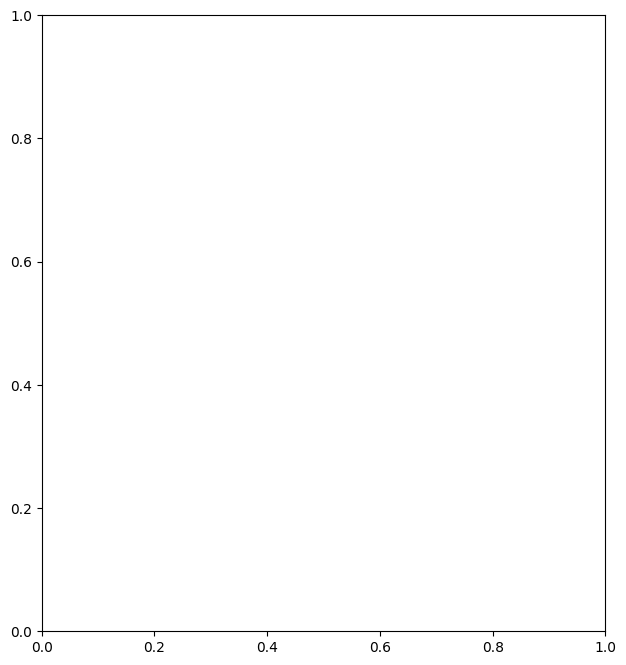

In [ ]:
# results Visualization

# create figures directory if it doesn't exist
figures_dir = Path("../figures")
figures_dir.mkdir(exist_ok=True, parents=True)

# plot perplexity comparison with tokenizer info
plt.figure(figsize=(16, 8))

# training perplexity
plt.subplot(1, 2, 1)
sns.barplot(x='config', y='train_ppl', hue='tokenizer_merges', data=all_results_df)
plt.title('Training Perplexity by Tokenizer')
plt.xlabel('Model Configuration')
plt.ylabel('Perplexity (lower is better)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='Tokenizer Merges')
plt.tight_layout()

# validation perplexity
plt.subplot(1, 2, 2)
sns.barplot(x='config', y='val_ppl', hue='tokenizer_merges', data=all_results_df)
plt.title('Validation Perplexity by Tokenizer')
plt.xlabel('Model Configuration')
plt.ylabel('Perplexity (lower is better)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='Tokenizer Merges')
plt.tight_layout()

plt.savefig("../figures/perplexity_by_tokenizer_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# plot training time comparison
plt.figure(figsize=(14, 6))
sns.barplot(x='config', y='train_time', hue='tokenizer_merges', data=all_results_df)
plt.title('Training Time Comparison by Tokenizer')
plt.xlabel('Model Configuration')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Tokenizer Merges')
plt.tight_layout()
plt.savefig("../figures/training_time_by_tokenizer_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# create a vocabulary size vs perplexity plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='vocab_size', y='train_ppl', hue='type', style='tokenizer_merges', 
                size='tokenizer_merges', sizes=(50, 200), data=all_results_df)
plt.title('Training Perplexity vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Training Perplexity')
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.scatterplot(x='vocab_size', y='val_ppl', hue='type', style='tokenizer_merges',
                size='tokenizer_merges', sizes=(50, 200), data=all_results_df)
plt.title('Validation Perplexity vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Validation Perplexity')
plt.yscale('log')

plt.tight_layout()
plt.savefig("../figures/perplexity_vs_vocab_size.png", dpi=300, bbox_inches='tight')
plt.show()

## Text Generation Comparison

Compare text generation quality between models.

In [ ]:
# display generated samples side by side
samples_df = all_results_df[['type', 'config', 'sample']]
samples_df = samples_df.sort_values(['type', 'config'])

print("Generated Text Samples:")
for _, row in samples_df.iterrows():
    print(f"\n{row['type']} - {row['config']}:")
    print(f"  \"{row['sample']}\"")

# create a more structured table view
html_table = "<table><tr><th>Model Type</th><th>Configuration</th><th>Generated Text</th></tr>"
for _, row in samples_df.iterrows():
    html_table += f"<tr><td>{row['type']}</td><td>{row['config']}</td><td>{row['sample']}</td></tr>"
html_table += "</table>"

from IPython.display import HTML
display(HTML(html_table))

NameError: name 'all_results_df' is not defined

# Conclusion

This notebook has demonstrated:

- A comprehensive comparison between classical N-gram models, neural N-gram models, and Mini-GPT architectures
- How tokenizer choices significantly impact language model performance, with larger vocabulary sizes not always producing better results
- The trade-off between model complexity and performance across different architectures

## Key observations:

- Classical N-gram models remain surprisingly effective for simple language tasks, especially with advanced smoothing techniques
- Neural models achieve lower perplexity but require significantly more training time compared to classical approaches
- Tokenizer choice is important
- Text generation quality doesn't always correlate with perplexity metrics, highlighting the importance of qualitative evaluation
